In [1]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt
import scipy

import sys
sys.path.append('..')
from cann import CANN1D

#set backend to cpu
bm.set_platform('cpu') 

/home/zilong/anaconda3/envs/hippocampalsequence/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1, simulate theta sweeps when varying m

In [3]:
sweep_cann_1 = CANN1D(tau=1, tau_v=48., num=128, mbar=4.5, A=0.005, sigma_u=0.01, sigma_m=0.01)
v_ext = sweep_cann_1.a / 144 * 0.55 
v_ext

0.0015277777777777779

In [2]:
def get_sweep_amp(mbar):
    
    #initialize the network
    sweep_cann_1 = CANN1D(tau=1, tau_v=48., num=128, mbar=mbar, A=0.005, sigma_u=0.01, sigma_m=0.01)
    sweep_cann_1.reset_state()
    
    v_ext = sweep_cann_1.a / 144 * 0.55   #animal speed
    sweep_dur = 2.5*np.pi / v_ext              #duration of simulation
    dt = bm.get_dt()                     #simulation time step                         
    steps = int(sweep_dur / dt)                #steps of simulation

    position = np.zeros(steps)
    position[0] = -np.pi/3               #initial position
    #generate position array
    for i in range(steps)[1:]:
        position[i] = position[i - 1] + v_ext * dt
        if position[i] > np.pi:          #periodic boundary condition
            position[i] -= 2 * np.pi

    position = position.reshape((-1, 1)) #reshape to (steps, 1) array to fit the input shape

    noise = 0.001*bm.random.randn(steps,sweep_cann_1.num) #add independent noise to the input with level 0.01

    #generate series of external input bump
    Iext = sweep_cann_1.get_stimulus_by_pos(position) + noise

    #simulate the network
    sweep_runner_1 = bp.DSRunner(sweep_cann_1,
                        inputs=('input', Iext, 'iter'),
                        monitors=['center','centerI'],
                        progress_bar=False)
    sweep_runner_1.run(sweep_dur)
    
    #visualize bump sweeps for 1 second. Cut the middle 1 second to avoid transient at the boundary
    time = np.linspace(0, sweep_dur, steps)    #time array
    time_start = int(1.9*bm.pi / v_ext/ dt)
    time_end = int(2.9*bm.pi / v_ext/ dt)
    time_slice=time[time_start:time_end]
    #subtract time 0 from time_slice
    time_slice = time_slice - time_slice[0]

    ##Theta oscillations
    relative_pos = sweep_runner_1.mon.center[time_start:time_end] - sweep_runner_1.mon.centerI[time_start:time_end]
    relative_pos = bm.where(relative_pos > np.pi, relative_pos - 2*np.pi,  relative_pos)
    relative_pos = bm.where(relative_pos < -np.pi, relative_pos + 2*np.pi,  relative_pos)
    relative_pos = np.squeeze(relative_pos)

    #get the mean relative position after taking the abs
    mean_relative_pos = np.mean(np.abs(relative_pos))
    
    mean_relative_pos_sign = np.mean(relative_pos)
    
    relative_pos_smooth = scipy.ndimage.filters.gaussian_filter1d(relative_pos, 200)
    peaks, _ = scipy.signal.find_peaks(relative_pos_smooth, height=0)
    troughs, _ = scipy.signal.find_peaks(-relative_pos_smooth, height=0)
    #get the values at the peaks and troughs and average them respectively
    mean_relative_pos_peak = np.mean(relative_pos_smooth[peaks])
    mean_relative_pos_trough = np.mean(relative_pos_smooth[troughs])
    
    #get the mean sweep amplitude
    mean_sweep_amp = mean_relative_pos_peak - mean_relative_pos_trough
    
    #del all variable to save memory
    del sweep_cann_1, sweep_runner_1, Iext, noise, position
    
    return mean_relative_pos, mean_relative_pos_sign, mean_sweep_amp, relative_pos


adaptation strength =  0.09375 sweep_mean =  0.6861414313316345 sweep_mean_sign =  0.0985698476433754 mean_sweep_amp =  1.5299664


/tmp/ipykernel_3050551/3374183845.py:53: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  relative_pos_smooth = scipy.ndimage.filters.gaussian_filter1d(relative_pos, 200)
/tmp/ipykernel_3050551/841411758.py:23: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  relative_pos_smooth = scipy.ndimage.filters.gaussian_filter1d(relative_pos, 200)


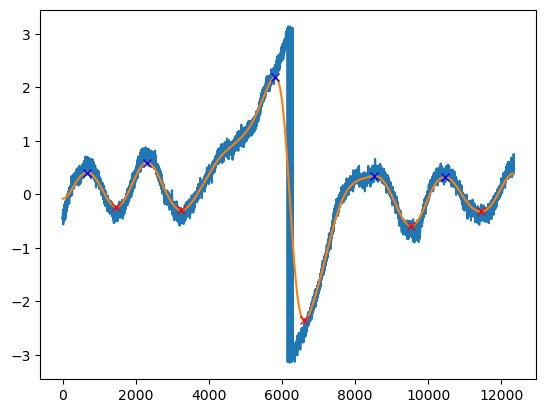

In [3]:
#vary mbar from 2 to 4 with 30 steps
mbars = [4.5]
simulation_nums = 1

M = np.zeros(len(mbars))
MeanSweep = np.zeros((simulation_nums, len(mbars)))
MeanSweepSign = np.zeros((simulation_nums, len(mbars))) 

for i, mbar in enumerate(mbars):
    
    m = mbar*1/48
    M[i] = m
    for j in range(simulation_nums):
        sweep_mean, sweep_mean_sign, mean_sweep_amp, relative_pos = get_sweep_amp(mbar)
        MeanSweep[j, i] = sweep_mean
        MeanSweepSign[j, i] = sweep_mean_sign
    
    #print mbar and sweep_mean in one line
    print("adaptation strength = ", m, "sweep_mean = ", np.mean(MeanSweep[:, i]), "sweep_mean_sign = ", np.mean(MeanSweepSign[:, i]), 'mean_sweep_amp = ', mean_sweep_amp)

plt.plot(relative_pos)
#Gaussian smooth the data with a window of 100 points
relative_pos_smooth = scipy.ndimage.filters.gaussian_filter1d(relative_pos, 200)
plt.plot(relative_pos_smooth)
#get the localized peaks and troughs
peaks, _ = scipy.signal.find_peaks(relative_pos_smooth, height=0)
troughs, _ = scipy.signal.find_peaks(-relative_pos_smooth, height=0)
#mark the peaks and troughs with blue and red dots
plt.plot(peaks, relative_pos_smooth[peaks], "x", color='blue')
plt.plot(troughs, relative_pos_smooth[troughs], "x", color='red')
    


In [4]:
#vary mbar from 2 to 4 with 30 steps
mbars = bm.linspace(2, 4, 15)
simulation_nums = 8

M = np.zeros(len(mbars))
MeanSweep = np.zeros((simulation_nums, len(mbars)))
MeanSweepSign = np.zeros((simulation_nums, len(mbars))) 
MeanSweepAmp = np.zeros((simulation_nums, len(mbars)))

for i, mbar in enumerate(mbars):
    
    m = mbar*1/48
    M[i] = m
    for j in range(simulation_nums):
        sweep_mean, sweep_mean_sign, mean_sweep_amp, relative_pos = get_sweep_amp(mbar)
        MeanSweep[j, i] = sweep_mean
        MeanSweepSign[j, i] = sweep_mean_sign
        MeanSweepAmp[j, i] = mean_sweep_amp
    
    #print mbar and sweep_mean in one line
    print("adaptation strength = ", m, "sweep_mean = ", np.mean(MeanSweep[:, i]), "sweep_mean_sign = ", np.mean(MeanSweepSign[:, i]), 'mean_sweep_amp = ', np.mean(MeanSweepAmp[:, i]))


/tmp/ipykernel_3050551/3374183845.py:53: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  relative_pos_smooth = scipy.ndimage.filters.gaussian_filter1d(relative_pos, 200)


adaptation strength =  0.041666668 sweep_mean =  0.09353605099022388 sweep_mean_sign =  0.02668828488094732 mean_sweep_amp =  0.15193838439881802
adaptation strength =  0.044642854 sweep_mean =  0.10074546281248331 sweep_mean_sign =  0.03187715995591134 mean_sweep_amp =  0.17497424222528934
adaptation strength =  0.04761905 sweep_mean =  0.10454845987260342 sweep_mean_sign =  0.03870551730506122 mean_sweep_amp =  0.19132080674171448
adaptation strength =  0.05059524 sweep_mean =  0.1116915550082922 sweep_mean_sign =  0.04313800483942032 mean_sweep_amp =  0.21112553589046001
adaptation strength =  0.053571433 sweep_mean =  0.11915255524218082 sweep_mean_sign =  0.05091860285028815 mean_sweep_amp =  0.24946214817464352
adaptation strength =  0.056547623 sweep_mean =  0.1351436423137784 sweep_mean_sign =  0.04234390705823898 mean_sweep_amp =  0.29325228184461594
adaptation strength =  0.05952381 sweep_mean =  0.12602838408201933 sweep_mean_sign =  0.05154011910781264 mean_sweep_amp =  0.2

### 2, simulating replay when varying m

In [ ]:
#log-log plot of the average step size against time bins
def get_diffusion_exponent(trajetory, plot=False, get_intercept=False): 
    
    #return plt
    all_timebins = np.arange(1,20,1)
    all_avg_steps = []
    for timeb in all_timebins:
        #trajectory is a 1D array with radians value, 
        #get the circular difference between each time bin
        all_steps = np.abs(np.diff(trajetory[::timeb])) 
        #all_steps = np.abs(trajetory[::timeb] - trajetory[timeb::timeb])
        #consider the periodic boundary condition if >pi or <-pi, then minus 2pi or plus 2pi
        all_steps = np.where(all_steps > np.pi, all_steps - 2*np.pi, all_steps)
        all_steps = np.where(all_steps < -np.pi, all_steps + 2*np.pi, all_steps)
        #get the average step size for each time bin
        avg_step = np.mean(all_steps)
        
        all_avg_steps.append(avg_step)
    #get the slope of the log-log plot
    slope, intercept = np.polyfit(np.log(all_timebins), np.log(all_avg_steps), 1)

    #print('The slope of the log-log plot is %.2f'%slope)
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(3,3))
        #plot the log-log plot and add the slope as a lagend
        ax.plot(all_timebins, all_avg_steps, 'o', color='black')
        #add shadow plot of the std
        #ax.fill_between(all_timebins, np.array(all_avg_steps), np.array(all_avg_steps), color='black', alpha=0.2)
        ax.plot(all_timebins, np.exp(intercept)*all_timebins**slope, 'r-', label='slope = %.2f'%slope)  
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Time bins')
        ax.set_ylabel('Average step size')
        ax.legend()
        #set both ticks to [0,10]
        ax.set_xticks([1,10])
        ax.set_yticks([1,10])
        if get_intercept:
            return fig, ax, slope, intercept
        else:
            return fig, ax, slope
    else:
        if get_intercept:
            return slope, intercept
        else:
            return slope
        


In [ ]:
def get_replay_exponent(mbar):
    replay_dur = 2000      #simulate 200 ms, roughly the length of a SWR
    init_dur = 50 #initial 10 ms to let the network settle

    #initialize the network
    replay_cann_1 = CANN1D(tau=1., tau_v=48., num=128, mbar=mbar, A=0.01, sigma_m=0.01, sigma_u=0.01)
    replay_cann_1.reset_state()
    Iext, length = bp.inputs.section_input(
        values=[replay_cann_1.get_stimulus_by_pos(-3/4*np.pi), 0.], #initial position of the bump
        durations=[init_dur, replay_dur],
        return_length=True
    )
    noise = 0.001* bm.random.randn(len(Iext), replay_cann_1.num) #add independent noise to the input with level 0.02
    Iext = Iext + noise
    Iext = bm.as_numpy(Iext)

    #run the network
    replay_runner_1 = bp.DSRunner(replay_cann_1,
                        inputs=('input', Iext, 'iter'),
                        monitors=['center'],
                        progress_bar=False)

    replay_runner_1.run(length)
    
    
    bum_center = replay_runner_1.mon.center
    #squeeze the array
    bum_center = np.squeeze(bum_center)
        
    slope = get_diffusion_exponent(bum_center, plot=False)
    
    #del all variable to save memory
    del replay_cann_1, replay_runner_1, Iext, noise, bum_center
    
    return slope


mbars = bm.linspace(2, 4, 15)
simulation_nums = 8
DiffusionExp = np.zeros((simulation_nums, len(mbars)))

for i, mbar in enumerate(mbars):
    m = mbar*1/48
    for j in range(simulation_nums):
        slope = get_replay_exponent(mbar)
        DiffusionExp[j, i] = slope
    #print mbar and the slope in a line
    print('adaptation strength = ', m, 'slope = ', slope)
    
    

In [ ]:
#using picle to store M, MeanSweep, DiffusionExp in to a file
import pickle
with open('./sweep_replay_correlation.pkl', 'wb') as f:
    pickle.dump([M, MeanSweep, MeanSweepAmp, DiffusionExp], f)


In [ ]:
#load the data from the pickle file
import pickle
with open('./sweep_replay_correlation.pkl', 'rb') as f:
    M, MeanSweep, MeanSweepAmp, DiffusionExp = pickle.load(f)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable



# Create a scatter plot
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))
labelsize = 10
ticksize = 8

cmap_user = 'GnBu'
# Create a colormap scalar map
norm = Normalize(vmin=np.min(M), vmax=np.max(M))
cmap = cm.get_cmap(cmap_user)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # An empty array to create the color mapping

simulation_nums = DiffusionExp.shape[0]
for i in range(simulation_nums):
    ax.scatter(MeanSweepAmp[i, :], DiffusionExp[i, :], c=M, cmap=cmap_user, s=20, alpha=0.8)

# Add a colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Adaptation strength', fontsize=labelsize)
#set colorbar ticks with fontsize ticksizes
cbar.ax.tick_params(labelsize=ticksize)

ax.set_xlabel('Average sweep length (cm)', fontsize=labelsize)
ax.set_ylabel('Diffusion exponent', fontsize=labelsize)
#set ticksizes
ax.tick_params(labelsize=ticksize)
#upper and right axis off
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()
